Create compression version of GPT-2 nad BERT model and save the memory =)

## cola example

The Semantic Textual Similarity Benchmark (Cer et al., 2017) is a collection of sentence pairs drawn from news headlines, video and image captions, and natural language inference data. Each pair is human-annotated with a similarity score from 0 to 5.

In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"


In [2]:
#!pip install Partial State

In [3]:
import transformers
print (transformers.__version__)

4.31.0


In [4]:
from sparse_grad_matrix_spars import replace_bert_layers #replace_bert_layers(model, UV_dict):

In [5]:
def sparse_grad_linear(model, UV_dict):
    print ("create bert with sparse grads")
    model = replace_bert_layers(model, UV_dict)
    print ("created bert with sparse grads")
    return model

In [6]:
from datasets import load_dataset
import pandas as pd

dataset_cola = load_dataset('glue', 'cola')
dataset_cola.num_rows

Found cached dataset glue (/root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

{'train': 8551, 'validation': 1043, 'test': 1063}

In [7]:
label_list = dataset_cola["train"].features["label"].names
num_labels = len(label_list)


In [8]:
task_num_labels = num_labels

from transformers import AutoConfig, BertConfig, AutoModelForSequenceClassification, AutoTokenizer

path_name = r"bert-base-uncased"

config = AutoConfig.from_pretrained(
    path_name,
    num_labels=num_labels,
)

model = AutoModelForSequenceClassification.from_pretrained(
    path_name,
    config=config,
)

tokenizer = AutoTokenizer.from_pretrained(path_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
#model=model.to('cuda:2')

In [10]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}
sentence1_key, sentence2_key = task_to_keys['cola']

In [11]:

def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
        )
        
        
        result = tokenizer.batch_encode_plus(*args, max_length=128, truncation=True, padding="max_length")

        result["label"] = examples["label"]
        return result

In [12]:
dataset_cola['train']

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 8551
})

In [13]:
tokenized_dataset = dataset_cola.map(
            preprocess_function,
            batched=True,
            load_from_cache_file=False
        )

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [14]:
tokenized_dataset['validation']

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1043
})

In [15]:
from transformers import Trainer
import evaluate as ev
import numpy as np

from transformers import TrainingArguments, Trainer, EvalPrediction

2023-08-07 19:10:17.602604: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [16]:
metric = ev.load("glue", 'cola')

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def compute_metrics(p: EvalPrediction):
        preds_ = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds_ = np.argmax(preds_, axis=1)
        
        result = metric.compute(predictions=preds_, references=p.label_ids)
        if True:
            result["combined_score"] = np.mean(list(result.values())).item()
            return result
        else:
            return {"accuracy": (preds_ == p.label_ids).astype(np.float32).mean().item()}

In [19]:
training_args1 = TrainingArguments(
    learning_rate=5e-5,
    num_train_epochs=1,
    evaluation_strategy="steps",
    eval_steps=100,
    max_steps = 11,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=1000,
    overwrite_output_dir=True,
    output_dir="./bert_stsb_128",
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

training_args2 = TrainingArguments(
    learning_rate=5e-5,
    num_train_epochs=1,
    evaluation_strategy="steps",
    skip_memory_metrics = False,
    eval_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=1000,
    overwrite_output_dir=True,
    output_dir="./bert_stsb_128",
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

In [20]:
from trainers_custom import TrainerBert1, TrainerBert2, TrainerDoubleOpt

In [21]:
trainer = TrainerBert1(
        model=model,
        args=training_args1,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics = compute_metrics,
)
trainer.make_grad_bank()

In [22]:
trainer.train_dataset

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8551
})

## BERT sparse

In [23]:

print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)


len small dataset 8551
lets collect gradients


/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


finishing collecting gradients


In [24]:
from sparse_grad_matrix_spars import Tucker_Decomposition
import torch

UV_dict = {}

grads1 = torch.stack(trainer.grads1[:120])
u1, VT, U = Tucker_Decomposition(grads1)
UV_dict.update({"output":tuple((U, VT))})
grads2 = torch.stack(trainer.grads2[:120])
u1, VT, U = Tucker_Decomposition(grads2)
UV_dict.update({"interm":tuple((U, VT))})

In [25]:
del grads1, grads2, trainer
torch.cuda.empty_cache()

In [26]:
model = sparse_grad_linear(model, UV_dict)

create bert with sparse grads
created bert with sparse grads


In [27]:
trainer = TrainerBert2(
        model=model,
        args=training_args2,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics = compute_metrics,
)


#trainer.create_scheduler(num_training_steps = trainer.max_steps)

trainer.make_grad_bank()

number of nonzero  tensor(336384)


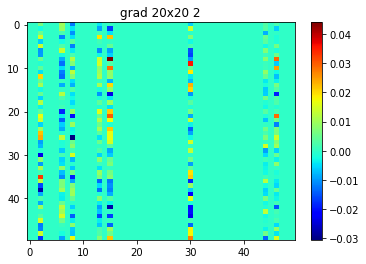

number of nonzero  tensor(1766399)


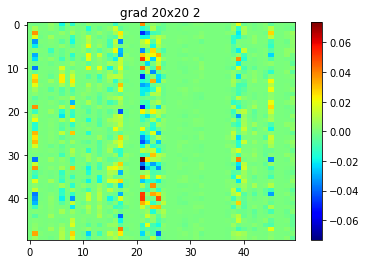

number of nonzero  tensor(439296)


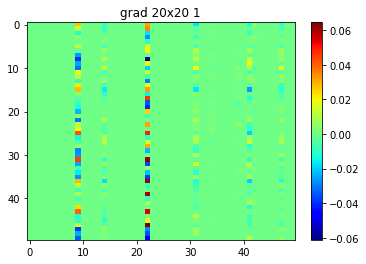

number of nonzero  tensor(1397760)


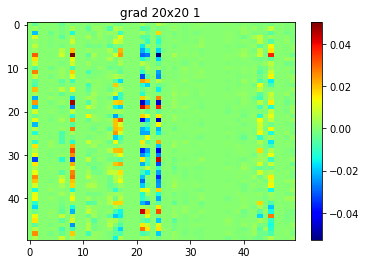

number of nonzero  tensor(43008)


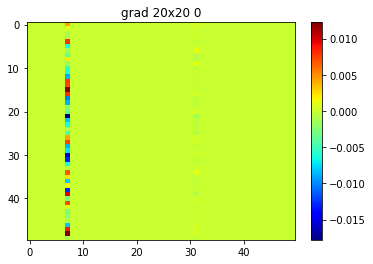

number of nonzero  tensor(1256448)


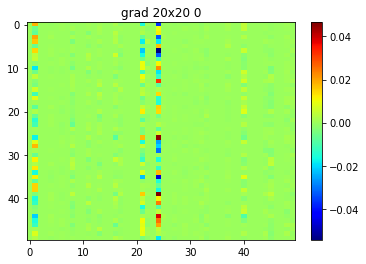

Step,Training Loss,Validation Loss,Matthews Correlation,Combined Score
100,No log,0.620562,0.000000,0.000000
200,No log,0.620307,0.000000,0.000000
300,No log,0.633026,0.000000,0.000000
400,No log,0.619915,0.000000,0.000000
500,0.616100,0.618202,0.000000,0.000000


In [28]:
train_result = trainer.train()

In [29]:
trainer.log_metrics("train", train_result.metrics)

***** train metrics *****
  before_init_mem_cpu        =     6099MB
  before_init_mem_gpu        =      716MB
  epoch                      =        1.0
  init_mem_cpu_alloc_delta   =        0MB
  init_mem_cpu_peaked_delta  =        0MB
  init_mem_gpu_alloc_delta   =        0MB
  init_mem_gpu_peaked_delta  =        0MB
  total_flos                 =   523836GF
  train_loss                 =     0.6149
  train_mem_cpu_alloc_delta  =      118MB
  train_mem_cpu_peaked_delta =     1009MB
  train_mem_gpu_alloc_delta  =     2795MB
  train_mem_gpu_peaked_delta =     3184MB
  train_runtime              = 0:02:46.68
  train_samples_per_second   =       51.3
  train_steps_per_second     =       3.21


In [29]:
from transformers import  TrainerCallback
import torch
import numpy as np
import time

class ProfCallback(TrainerCallback):
    def __init__(self, prof):
        self.prof = prof

    def on_step_end(self, args, state, control, **kwargs):
        self.prof.step()


In [30]:
profiler_result_path = 'file.json'
def train_on_epoch(generator, model, loss_function, optimizer):
    model.train()
    epoch_loss = []
    for batch_of_x, batch_of_y in generator:
        optimizer.zero_grad()
        with torch.autograd.profiler.profile(use_cuda=True, record_shapes=True, with_flops=True, profile_memory=True) as prof:
            output = model(batch_of_x)
            loss = loss_function(output, batch_of_y)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item()) 
    
    prof.export_chrome_trace(profiler_result_path)

number of nonzero  tensor(347136)


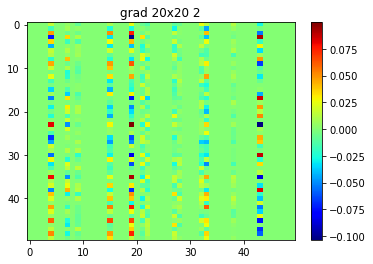

number of nonzero  tensor(1794048)


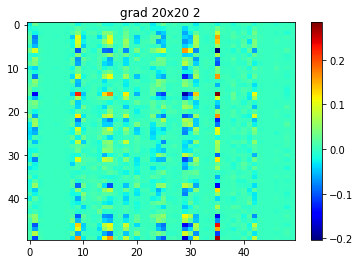

number of nonzero  tensor(391680)


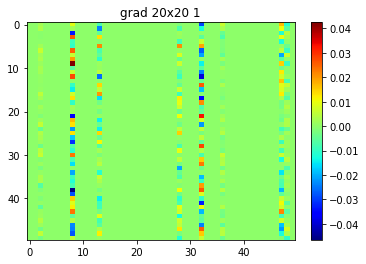

number of nonzero  tensor(1489920)


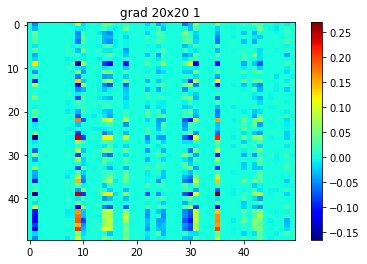

number of nonzero  tensor(43776)


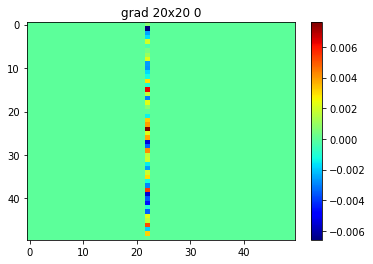

number of nonzero  tensor(1256448)


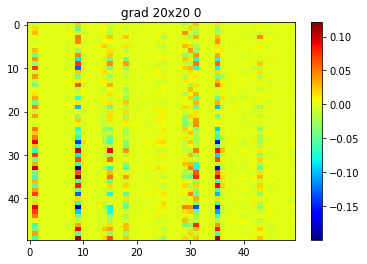

Step,Training Loss,Validation Loss,Matthews Correlation,Combined Score
100,No log,0.619056,0.000000,0.000000
200,No log,0.620313,0.000000,0.000000
300,No log,0.635708,0.000000,0.000000
400,No log,0.619889,0.000000,0.000000
500,0.616700,0.618193,0.000000,0.000000


[W CPUAllocator.cpp:305] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event


RuntimeError: Trace is already saved

In [29]:
import torch
with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU,
                                        torch.profiler.ProfilerActivity.CUDA], 
                            schedule=torch.profiler.schedule(skip_first=3, wait=1, warmup=1, active=2, repeat=2),
                            on_trace_ready=torch.profiler.tensorboard_trace_handler('hf-training-trainer'),
                            profile_memory=True,
                            with_stack=True,
                            record_shapes=True) as prof:
    
    trainer.add_callback(ProfCallback(prof=prof))
    train_result = trainer.train()
    prof.export_chrome_trace(profiler_result_path)

In [ ]:
trainer.evaluate()

In [ ]:
import pickle
d = pickle.load( open( "/notebook/compression/exps/cola_pickles/bert_eval.pkl", "rb" ) )

In [ ]:
e = pickle.load( open( "/notebook/compression/exps/cola_pickles/bert_eval_sp.pkl", "rb" ) ) 

In [ ]:
len(eval_losses)

In [ ]:
eval_losses.append(0.4231)

In [ ]:
eval_losses

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.array(d), label = "bert full")
plt.plot(np.array(eval_losses), label = "sparse bert sharing")
plt.plot(np.array(e), label = "sparse bert")
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import pickle
d = pickle.load( open( "/notebook/compression/exps/cola_pickles/bert.pkl", "rb" ) ) 

plt.plot(np.mean(np.array(d)[:500].reshape(-1, 50), axis=1), label = "bert full")
plt.plot(np.mean(np.array(trainer.losses)[:500].reshape(-1, 50), axis=1), label = "sparse bert")
plt.legend()

In [ ]:
/notebook/compression/exps

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.mean(np.array(d)[:500].reshape(-1, 50), axis=1), label = "bert full")
plt.plot(np.mean(np.array(trainer.losses)[:500].reshape(-1, 50), axis=1), label = "sparse bert")
plt.legend()

In [ ]:
eval_losses = [elem['eval_loss'] for elem in trainer.state.log_history if 'eval_loss' in elem.keys()]
import pickle
with open('/notebook/compression/exps/cola_pickles/bert_eval_sp_001.pkl', 'wb') as f:
    pickle.dump(np.array(eval_losses), f)

In [ ]:
#train_result = trainer.train()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.mean(np.array(d)[:500].reshape(-1, 50), axis=1), label = "bert full")
plt.plot(np.mean(np.array(trainer.losses)[:500].reshape(-1, 50), axis=1), label = "sparse bert")
plt.legend()

In [ ]:
trainer.evaluate()

In [ ]:
trainer.log_metrics("train", train_result.metrics)

In [ ]:
class ProfCallback(TrainerCallback):
    def __init__(self, prof):
        self.prof = prof

    def on_step_end(self, args, state, control, **kwargs):
        self.prof.step()
